In [3]:
%load_ext autoreload
%autoreload 2

In [50]:
import os
import pykeen
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations, WN18RR, FB15k237
from pykeen.pipeline import pipeline
from pykeen import predict
from statistics import mean, median
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from itertools import chain
from pathlib import Path
from rich import print
from tqdm import tqdm

from utils import prepare_for_visualization

## Settings

In [10]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

## Loading data

In [54]:
DATASET_PATH = Path("data/FB15k237")

In [55]:
dataset = PathDataset(
    WN18RR_PATH / "train.tsv",
    WN18RR_PATH / "test.tsv",
    WN18RR_PATH / "valid.tsv",
)

g = nx.DiGraph()
g.add_edges_from([(h, t, {"title": r}) for h, r, t in dataset.training.triples])

## Visualization

In [61]:
_list_nodes = list(g.nodes)
@interact
def visualize(nodes=widgets.SelectMultiple(options=list(g.nodes),  rows=10, value=[_list_nodes[0]]), k=[0, 1,2,3], toggle_physics=False):
    filtered = set(chain(*[list(nx.single_source_shortest_path_length(g, n, cutoff=k)) for n in nodes]))
    # print(filtered)
    subgraph = nx.subgraph_view(g, filter_node=lambda x: x in filtered)
    nt = Network("500px", "500px", directed=True, notebook=True)
    nt.inherit_edge_colors(False)
    nt.from_nx(subgraph)
    nt.toggle_physics(toggle_physics)
    display(nt.show("basic.html"))
    

interactive(children=(SelectMultiple(description='nodes', index=(0,), options=("'N Sync", 'Grammy Award for Be…

## EDA

In [62]:
data = []
for subset_name in ["training", "validation", "testing"]:
    subset_metrics = {"subset": subset_name}
    subset = dataset.__getattribute__(subset_name)
    triples = subset.triples
    subset_metrics["num_triples"] = len(triples)
    subset_metrics["num_entities"] = len(np.unique(triples[:, [0,2]]))
    subset_metrics["num_relations"] = len(np.unique(triples[:, 1]))
    data.append(subset_metrics)

pd.DataFrame(data)

,subset,num_triples,num_entities,num_relations
0,training,271524,14233,237
1,validation,17519,9705,223
2,testing,20432,10212,224


In [63]:
metrics = {}

metrics["n_connected_components"] = nx.number_connected_components(g.to_undirected())
metrics["mean_size_of_connected_components"] = mean(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["median_size_of_connected_components"] = median(
    len(c) for c in nx.connected_components(g.to_undirected())
)
metrics["density"] = nx.density(g)
metrics["number_of_selfloops"] = nx.number_of_selfloops(g)
# metrics["degree_centrality"] = nx.degree_centrality(g)
# metrics["in_degree_centrality"] = nx.in_degree_centrality(g)
# metrics["out_degree_centrality"] = nx.out_degree_centrality(g)
# metrics["closeness_centrality"] = nx.closeness_centrality(g)
metrics["average_clustering"] = nx.average_clustering(g)

pd.DataFrame({"training":metrics})

,training
average_clustering,0.14845
density,0.00121
mean_size_of_connected_components,2846.60000
median_size_of_connected_components,2.00000
n_connected_components,5.00000
number_of_selfloops,1158.00000


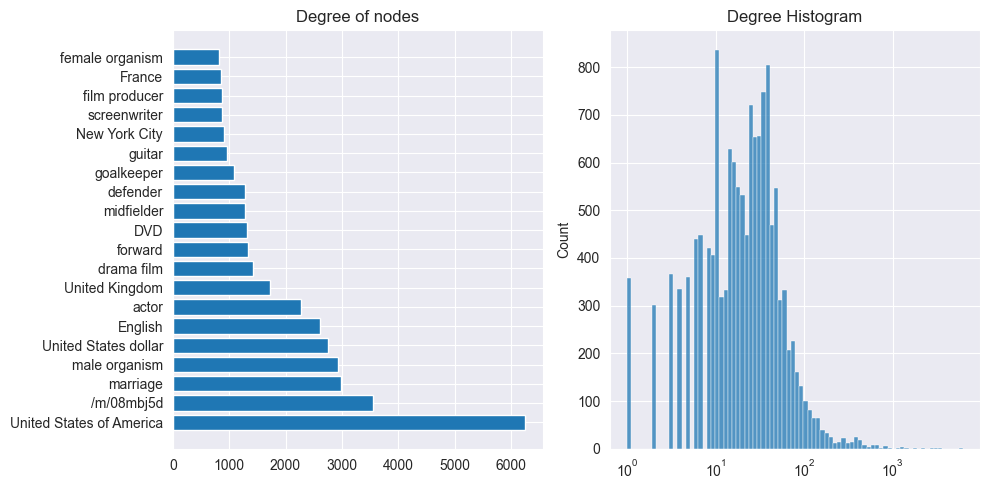

In [64]:
degree_sequence = sorted(g.degree(), key=lambda x: x[1], reverse=True)[:20]

x, y = zip(*degree_sequence)
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].set_title("Degree of nodes")
axes[0].barh(y=x, width=y)
axes[1].set_title("Degree Histogram")
sns.histplot([d for n, d in g.degree()], ax=axes[1], log_scale=True)
plt.tight_layout()

## Training 

In [65]:
result = pipeline(
    dataset=dataset,
    model="TransE",
    model_kwargs={"embedding_dim": 32},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=50,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    random_seed=123,
)

INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/50 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.


Evaluating on cpu:   0%|          | 0.00/20.4k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 61.37s seconds


In [66]:
save_location = Path("results")
save_location.mkdir(exist_ok=True)
result.save_to_directory(save_location)
print(f"Saved: {os.listdir(save_location)}")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14233, num_relations=237, create_inverse_triples=False, num_triples=271524, path="/home/albert/dev/kg-workshop-23/data/FB15k237/train.tsv") to file:///home/albert/dev/kg-workshop-23/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/albert/dev/kg-workshop-23/results


Saved: ['metadata.json', 'results.json', 'training_triples', 'trained_model.pkl']

## Metrics

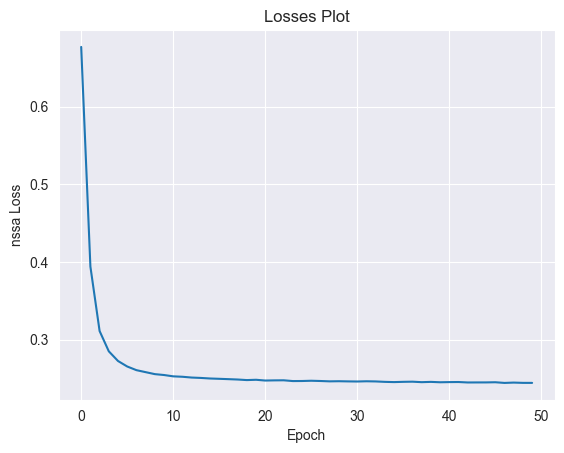

In [67]:
result.plot_losses()
plt.show()

In [68]:
metrics = result.metric_results.to_df()

In [69]:
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,inverse_harmonic_mean_rank,0.21378
14,both,realistic,inverse_geometric_mean_rank,0.03589
23,both,realistic,variance,374911.43750
32,both,realistic,arithmetic_mean_rank,234.31000
41,both,realistic,median_rank,26.00000
50,both,realistic,inverse_median_rank,0.03846
59,both,realistic,z_arithmetic_mean_rank,338.01580
68,both,realistic,z_geometric_mean_rank,201.44390
77,both,realistic,adjusted_arithmetic_mean_rank_index,0.96667
86,both,realistic,adjusted_inverse_harmonic_mean_rank,0.21321


## Embeddings visualization

In [70]:
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14233, 32)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(237, 32)
    )
  )
  (weight_regularizers): ModuleList()
)

In [71]:
embeddings = result.model.entity_representations[0](torch.arange(dataset.num_entities))
labels = [dataset.training.entity_id_to_label[i] for i in range(dataset.num_entities)]

In [72]:
prepare_for_visualization(embeddings.detach().numpy(), labels, Path("logs/FB15k237"))

In [ ]:
!tensorboard --logdir=logs/FB15k237

2023-06-13 20:28:01.559496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.0 at http://localhost:6006/ (Press CTRL+C to quit)
